### A Detailed Look at *topleft-corner* Regression Task

In [1]:
import os, sys
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

In [2]:
path = untar_data(URLs.MNIST_TINY)

In [3]:
df = pd.DataFrame({'fn':[],'y':[]})

for digit_cat in os.listdir(path/'train'):
    
    tmp = [f'/train/{digit_cat}/{e}' for e in 
           os.listdir(path/'train'/str(digit_cat))] 
    df_tmp = pd.DataFrame({'fn': tmp})
    df_tmp['y'] = digit_cat
    df = pd.concat((df, df_tmp))
    
df['y'] = df['y'].astype('float')
df.reset_index(inplace=True)

In [4]:
def point_from_img(fn):

    img_np = np.array(Image.open(str(path) + fn))

    img_bool =         np.where(img_np > 0, 1, 0)
    row_sums =         img_bool.argmax(axis=1)
    binary_row_sums =  np.where(row_sums > 0, 1, 0)
    top_row_index =    binary_row_sums.tolist().index(1)
    top_row_values =   img_np[top_row_index,:]
    leftmost_index =   (top_row_values > 0).tolist().index(True)


    return (top_row_index, leftmost_index)

vals = [point_from_img(e) for e in df['fn']]
df_p = pd.DataFrame(vals, columns=['py','px'])
df = pd.concat((df,df_p ), axis=1)

In [5]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(['px', 'py'])
                  )

dls = dblock.dataloaders(df)

### Modelling

In [9]:
learn = cnn_learner(dls, 
                    resnet18, 
                    pretrained=True, 
                    y_range=(-1.,1.),
                   )

In [10]:
learn.fine_tune(50, cbs=CSVLogger(fname='mnist-4-1.csv'))

epoch,train_loss,valid_loss,time
0,0.606786,0.091752,00:05


epoch,train_loss,valid_loss,time
0,0.541679,0.087701,00:08
1,0.520075,0.140088,00:08
2,0.523253,0.177976,00:08
3,0.515076,0.195330,00:08
4,0.502794,0.200745,00:08
5,0.479685,0.237944,00:08
6,0.462096,0.232629,00:08
7,0.444746,0.196898,00:08
8,0.424433,0.183847,00:08
9,0.404806,0.180502,00:08


In [13]:
learn.save('mnist4-1')

In [14]:
df = pd.read_csv('mnist-4-1.csv')

In [19]:
learn.fine_tune(20, cbs=CSVLogger(fname='mnist-4-1b.csv'))

epoch,train_loss,valid_loss,time
0,0.041269,0.043422,00:05


epoch,train_loss,valid_loss,time
0,0.043995,0.040625,00:08
1,0.040718,0.037576,00:09
2,0.041007,0.035061,00:08
3,0.040230,0.033275,00:09
4,0.039580,0.034639,00:09
5,0.040017,0.031268,00:08
6,0.038423,0.025383,00:08
7,0.037045,0.024313,00:08
8,0.035483,0.023092,00:08
9,0.034171,0.023514,00:08


In [20]:
learn.save('mnist4-2')

In [21]:
learn.fine_tune(20, cbs=CSVLogger(fname='mnist-4-1c.csv'))

epoch,train_loss,valid_loss,time
0,0.019209,0.024102,00:06


epoch,train_loss,valid_loss,time
0,0.024580,0.023176,00:08
1,0.020887,0.022382,00:09
2,0.018448,0.022913,00:09
3,0.017408,0.022143,00:08
4,0.017711,0.022792,00:08
5,0.019342,0.024783,00:08
6,0.019073,0.022864,00:08
7,0.018588,0.021844,00:08
8,0.018312,0.021339,00:08
9,0.018339,0.020959,00:08


In [98]:
learn.save('mnist4-3')

In [5]:
! cat mnist-4-1.csv

epoch,train_loss,valid_loss,time
0,0.5416790246963501,0.08770118653774261,00:08
1,0.520074725151062,0.14008751511573792,00:08
2,0.5232527852058411,0.17797645926475525,00:08
3,0.5150761008262634,0.19532980024814606,00:08
4,0.502793550491333,0.2007453888654709,00:08
5,0.47968536615371704,0.23794396221637726,00:08
6,0.462095707654953,0.23262909054756165,00:08
7,0.44474563002586365,0.19689823687076569,00:08
8,0.4244334101676941,0.1838466376066208,00:08
9,0.4048060476779938,0.18050213158130646,00:08
10,0.38372495770454407,0.16943420469760895,00:08
11,0.36295342445373535,0.13297288119792938,00:08
12,0.3398037850856781,0.1321018785238266,00:08
13,0.3140738904476166,0.10056301206350327,00:08
14,0.2911490797996521,0.07844564318656921,00:08
15,0.26479020714759827,0.06284494698047638,00:08
16,0.24249404668807983,0.07179861515760422,00:08
17,0.2229119837284088,0.06334797292947769,00:08
18,0.20409280061721802,0.06385091692209244,00:08
19,0.1876240074634552,0.051274675875902176,00:08
20,0.1718564778

In [ ]:
# I wonder if there are different means for 3 and 7
    # could there be a new baseline for taking this into account?
# I wonder what would happend if we introduced new digits?
# This is a pretty difficult task, it could be made easier by taking 
    # into account the 
# should add MAE as a metric

In [ ]:
preds = learn.get_preds(with_loss=True)

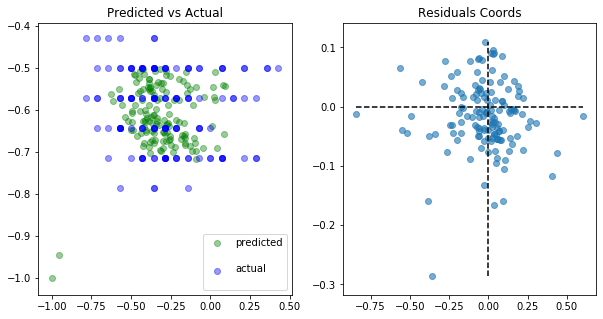

In [31]:
predicts = preds[0]
predicts_x, predicts_y = predicts[:,0], predicts[:,1]

actuals = preds[1].view(-1,2)
actuals_x, actuals_y = actuals[:,0], actuals[:,1]

resids = predicts - actuals
resids_x = resids.view(-1,2)[:,0]
resids_y = resids.view(-1,2)[:,1]

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(preds[0][:, 0], preds[0][:, 1], c='g', alpha=0.4)
ax[0].scatter(preds[1].view(-1,2)[:, 0], preds[1].view(-1,2)[:, 1], c='b', alpha=0.4)
ax[0].legend(['predicted', '\nactual\n'])
ax[0].set_title('Predicted vs Actual')

ax[1].scatter(resids_x, resids_y, alpha=0.6);
ax[1].vlines(0, min(resids_y), max(resids_y), linestyle='--');
ax[1].hlines(0, min(resids_x), max(resids_x), linestyle='--');
ax[1].set_title('Residuals Coords');

In [41]:
y_train = [xy[1] for xy in dls.dataset]
y_valid = [xy[1] for xy in dls.valid_ds]
n_train, n_valid, n = len(y_train), len(y_valid), len(y_train) + len(y_valid)
print(f'total n: {n} | train: {n_train} | len valid: {n_valid}')

total n: 709 | train: 568 | len valid: 141


In [35]:
len(y_train)

568

In [44]:
!ls mnist-4*.csv

mnist-4-1b.csv	mnist-4-1c.csv	mnist-4-1.csv


##### Read in history

In [82]:
df_1 = pd.read_csv('mnist-4-1.csv')
df_2 = pd.read_csv('mnist-4-1b.csv')
df_3 = pd.read_csv('mnist-4-1c.csv')

counter = 0
df = pd.DataFrame([])
for _df in [df_1, df_2, df_3]:
    _df['epoch'] = _df['epoch'] + counter
    df = pd.concat((df, _df), axis=0)
    counter += len(_df)

df.reset_index(drop=True, inplace=True)

In [83]:

df

,epoch,train_loss,valid_loss,time
0,0,0.541679,0.087701,00:08
1,1,0.520075,0.140088,00:08
2,2,0.523253,0.177976,00:08
3,3,0.515076,0.195330,00:08
4,4,0.502794,0.200745,00:08
...,...,...,...,...
85,85,0.016151,0.020328,00:08
86,86,0.015644,0.020353,00:08
87,87,0.015312,0.020221,00:08
88,88,0.014645,0.020226,00:08


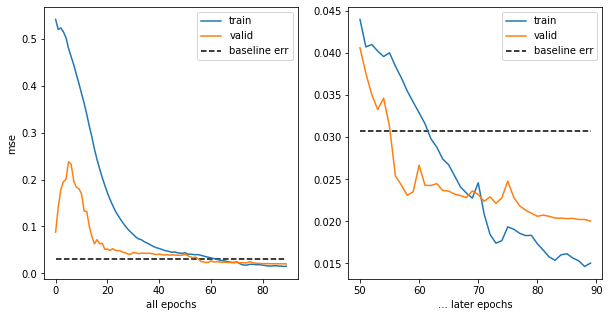

In [95]:
epoch_cutoff = 50
baseline_err = 0.0307

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(df['train_loss'])
ax[0].plot(df['valid_loss'])
if baseline_err is not None:
    ax[0].hlines(baseline_err,0, max(df['epoch']),
                linestyle='--')
ax[0].set_ylabel('mse')
ax[0].set_xlabel('all epochs')
ax[0].legend(['train', 'valid', 'baseline err'])

ax[1].plot(df['train_loss'].iloc[epoch_cutoff:])
ax[1].plot(df['valid_loss'].iloc[epoch_cutoff:])
ax[1].set_xlabel('... later epochs')
if baseline_err is not None:
    ax[1].hlines(baseline_err,epoch_cutoff, max(df['epoch']),
                linestyle='--')
ax[1].legend(['train', 'valid', 'baseline err'])


In [84]:
df['train_loss']

0     0.541679
1     0.520075
2     0.523253
3     0.515076
4     0.502794
        ...   
85    0.016151
86    0.015644
87    0.015312
88    0.014645
89    0.015043
Name: train_loss, Length: 90, dtype: float64

In [96]:
learn.path

Path('.')

In [97]:
learn.save('hql')